<a href="https://colab.research.google.com/github/ramiz11/Yelp-EDA/blob/main/yelp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [*Yelp*](https://en.wikipedia.org/wiki/Yelp) dataset EDA: Cleveland restaurants

By Rami Zaboura and Amir Ashiri

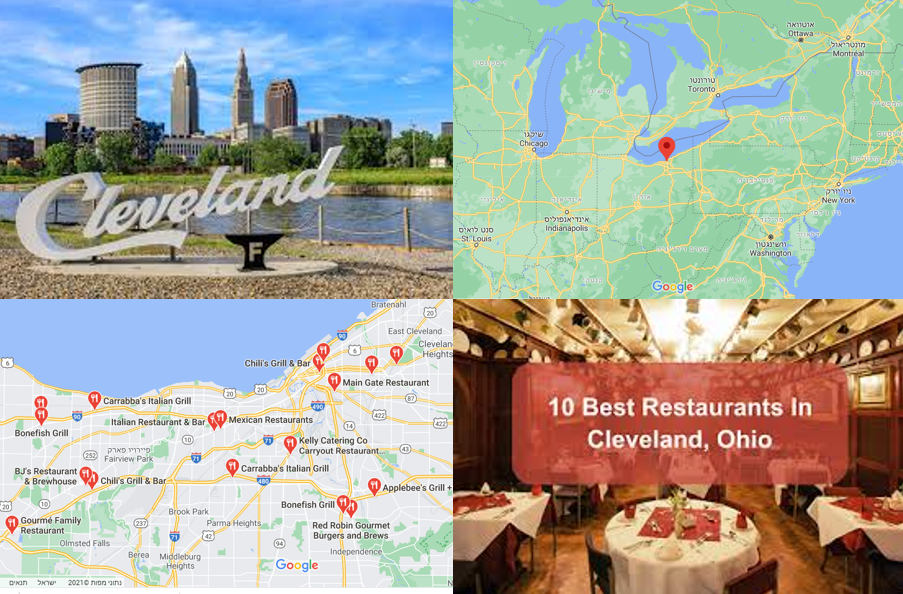

## Setup & Read the data

The data selection and preparation is described in the [yelp data selection notebook](https://github.com/ramiz11/Yelp-EDA/blob/main/yelp_data_selection.ipynb) .
It has been run locally and uploaded to Github, in order to deal with Github's upload size limitation.
The selected subset for analysis: restaurants in Cleveland, OH, along with their corresponding reviews, users, and check-in information.

##### Setup

In [156]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import json
!pip install flat_table
import flat_table
from os.path import join
from os import path
from urllib.request import urlopen
import pickle
import ast
from distutils.util import strtobool
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
plt.style.use('ggplot');
!pip install afinn
from afinn import Afinn
from nltk.corpus import stopwords
import nltk

### set display options and bold text print function
pd.set_option('max_rows', 100)
pd.set_option('max_colwidth', 400)

from IPython.display import Markdown, display
def printbold(string):
    display(Markdown(string))

##### Read the already-subset data from github


In [157]:
url="http://raw.githubusercontent.com/ramiz11/Yelp-EDA/main/"
business = pickle.load(urlopen(join(url, 'business.pkl')))
checkin = pickle.load(urlopen(join(url, 'checkin.pkl')))
review = pickle.load(urlopen(join(url, 'review.pkl')))
user = pickle.load(urlopen(join(url, 'user.pkl')))

## Businesses general information

##### Businesses should contain all Yelp restaurants in Cleveland. Let's verify:

In [158]:
business.city.value_counts(dropna=False)

Cleveland    1550
Name: city, dtype: int64

So we have 1550 Cleveland restaurants. What info do we have there?

In [159]:
business.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1550 entries, 41 to 209221
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   1550 non-null   object 
 1   name          1550 non-null   object 
 2   address       1550 non-null   object 
 3   city          1550 non-null   object 
 4   state         1550 non-null   object 
 5   postal_code   1550 non-null   object 
 6   latitude      1550 non-null   float64
 7   longitude     1550 non-null   float64
 8   stars         1550 non-null   float64
 9   review_count  1550 non-null   int64  
 10  is_open       1550 non-null   int64  
 11  attributes    1508 non-null   object 
 12  categories    1550 non-null   object 
 13  hours         1187 non-null   object 
dtypes: float64(3), int64(2), object(9)
memory usage: 181.6+ KB


##### No missing values,  except for hours - checking if anything stands out in these rows shows nothing special/problematic, so it's probably just restaurants for which Yelp does not have the opening hours

In [160]:
business[business.hours.isnull()].head(3)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
623,7LzhLKAwS7PHUvaPIW833A,Dominic's Santos,21467 Lorain Rd,Cleveland,OH,44126,41.443652,-81.858176,3.5,40,1,"{'Caters': 'True', 'OutdoorSeating': 'True', 'RestaurantsGoodForGroups': 'True', 'Alcohol': 'u'beer_and_wine'', 'RestaurantsTakeOut': 'True', 'BusinessParking': '{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}', 'RestaurantsReservations': 'True', 'GoodForKids': 'True', 'RestaurantsAttire': 'u'casual'', 'NoiseLevel': 'u'average'', 'BusinessAcceptsCreditCards'...","Italian, Pizza, Restaurants, American (Traditional)",None
966,fhTTP5HRqOzmFw-31Qe7QA,Mario's Fish Bowl,3962 Mayfield Rd,Cleveland,OH,44121,41.520361,-81.538109,2.0,4,0,"{'OutdoorSeating': 'True', 'RestaurantsReservations': 'False', 'BusinessAcceptsCreditCards': 'True', 'RestaurantsAttire': ''casual'', 'GoodForKids': 'False', 'BikeParking': 'False', 'NoiseLevel': 'u'loud'', 'Alcohol': ''full_bar'', 'Caters': 'False', 'HasTV': 'True', 'RestaurantsDelivery': 'False', 'BusinessParking': '{'garage': False, 'street': False, 'validated': False, 'lot': False, 'valet'...","Seafood, Pizza, Restaurants, Bars, Nightlife, Pet Stores, Pubs, Pets, Food, Beer, Wine & Spirits",None
1585,4juuUn_vuJLP4MMFJetXfw,Jazz 28,1332 Carnegie Ave,Cleveland,OH,44113,41.497138,-81.679283,4.0,3,0,"{'RestaurantsGoodForGroups': 'False', 'BusinessParking': '{'garage': False, 'street': False, 'validated': False, 'lot': False, 'valet': False}', 'BusinessAcceptsCreditCards': 'True', 'OutdoorSeating': 'False', 'GoodForKids': 'False', 'RestaurantsPriceRange2': '2'}","Music Venues, French, Jazz & Blues, Tapas Bars, Restaurants, Nightlife, Arts & Entertainment, American (New)",None


## Key measures

##### View numerical columns

In [161]:
business.describe()

,latitude,longitude,stars,review_count,is_open
count,1550.000000,1550.000000,1550.000000,1550.000000,1550.000000
mean,41.480909,-81.680846,3.491935,60.412258,0.693548
std,0.039813,0.081324,0.879671,111.885096,0.461168
min,41.312880,-81.866362,1.000000,3.000000,0.000000
25%,41.459236,-81.723337,3.000000,7.000000,0.000000
50%,41.488405,-81.690369,3.500000,20.000000,1.000000
75%,41.501635,-81.627517,4.000000,62.000000,1.000000
max,41.611857,-81.436705,5.000000,1372.000000,1.000000


In [162]:
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
41,98hyK2QEUeI8v2y0AghfZA,Pho Lee's Vietnamese Restaurant,"1541 E 38th St, Ste 101",Cleveland,OH,44114,41.512155,-81.663332,4.5,23,1,"{'BusinessParking': 'None', 'Ambience': '{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': False, 'upscale': False, 'classy': False, 'casual': False}', 'BYOB': 'False', 'GoodForMeal': '{'dessert': False, 'latenight': False, 'lunch': False, 'dinner': False, 'brunch': False, 'breakfast': False}', 'Corkage': 'False', 'BusinessAcceptsCreditCards'...","Restaurants, Vietnamese, Soup","{'Monday': '11:0-20:0', 'Wednesday': '11:0-20:0', 'Thursday': '11:0-20:0', 'Friday': '11:0-20:0', 'Saturday': '11:0-20:0', 'Sunday': '11:0-20:0'}"
49,tLpkSwdtqqoXwU0JAGnApw,Wendy's,4602 Northfield Road,Cleveland,OH,44128,41.434614,-81.527026,3.5,7,1,"{'RestaurantsDelivery': 'False', 'BusinessAcceptsCreditCards': 'True', 'GoodForKids': 'True', 'OutdoorSeating': 'False', 'NoiseLevel': 'u'average'', 'RestaurantsAttire': 'u'casual'', 'Ambience': '{'romantic': False, 'intimate': False, 'touristy': False, 'hipster': False, 'divey': False, 'classy': False, 'trendy': False, 'upscale': False, 'casual': False}', 'Caters': 'False', 'RestaurantsPriceR...","Restaurants, Fast Food, Burgers","{'Monday': '10:0-3:0', 'Tuesday': '10:0-3:0', 'Wednesday': '10:0-3:0', 'Thursday': '10:0-3:0', 'Friday': '10:0-3:0', 'Saturday': '10:0-3:0', 'Sunday': '10:0-3:0'}"
54,lK-wuiq8b1TuU7bfbQZgsg,Hingetown,,Cleveland,OH,44113,41.489343,-81.711029,3.0,4,1,"{'Alcohol': 'u'none'', 'GoodForKids': 'True', 'RestaurantsPriceRange2': '4', 'RestaurantsTakeOut': 'False', 'Caters': 'True', 'OutdoorSeating': 'True', 'RestaurantsDelivery': 'False', 'BusinessParking': '{'garage': False, 'street': False, 'validated': False, 'lot': False, 'valet': False}', 'WiFi': 'u'no'', 'RestaurantsAttire': 'u'formal'', 'BikeParking': 'False', 'NoiseLevel': 'u'very_loud'', ...","Shopping Centers, Food, Coffee & Tea, Cafes, Museums, Restaurants, Shopping, Local Flavor, Flowers & Gifts, Arts & Entertainment, Art Galleries, Florists","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'Wednesday': '0:0-0:0', 'Thursday': '0:0-0:0', 'Friday': '0:0-0:0', 'Saturday': '0:0-0:0', 'Sunday': '0:0-0:0'}"
173,rzd_2GJpkvHPejEwJ-IKHg,Somer's Restaurant,4197 W 150th St,Cleveland,OH,44135,41.440266,-81.800295,3.5,32,0,"{'NoiseLevel': 'u'average'', 'GoodForKids': 'True', 'BikeParking': 'True', 'RestaurantsDelivery': 'False', 'Caters': 'False', 'BusinessAcceptsCreditCards': 'True', 'OutdoorSeating': 'False', 'BusinessParking': '{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}', 'RestaurantsGoodForGroups': 'True', 'RestaurantsTakeOut': 'True', 'RestaurantsAttire': 'u'casual'',...","Diners, American (Traditional), Restaurants","{'Monday': '5:30-22:0', 'Tuesday': '5:30-22:0', 'Wednesday': '5:30-22:0', 'Thursday': '5:30-23:0', 'Friday': '5:30-23:0', 'Saturday': '5:30-23:0', 'Sunday': '5:30-21:0'}"
623,7LzhLKAwS7PHUvaPIW833A,Dominic's Santos,21467 Lorain Rd,Cleveland,OH,44126,41.443652,-81.858176,3.5,40,1,"{'Caters': 'True', 'OutdoorSeating': 'True', 'RestaurantsGoodForGroups': 'True', 'Alcohol': 'u'beer_and_wine'', 'RestaurantsTakeOut': 'True', 'BusinessParking': '{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}', 'RestaurantsReservations': 'True', 'GoodForKids': 'True', 'RestaurantsAttire': 'u'casual'', 'NoiseLevel': 'u'average'', 'BusinessAcceptsCreditCards'...","Italian, Pizza, Restaurants, American (Traditional)",None


* Half the restaurants have 20 reviews or more
* At least 50% of the restaurants are open
* The stars ratings median is 3.5, with almost identical mean

  Let's explore these further, starting with open vs. closed businesses



##### Open vs. closed restaurants

In [163]:
import plotly.express as px
open_counts = business.is_open.value_counts()
open_counts.index = ['Open', 'Closed']
fig = px.pie(open_counts, values=open_counts, names=open_counts.index.values, title='Try hovering over the slices!', hole=0.35)
fig.update_traces(hoverinfo='value', textinfo='percent', textfont_size=20)
fig.update_layout(legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01))
fig.show()

##### So about 70% of the restaurants are open, let's check how many reviews they get

In [164]:
open=business[business.is_open==1]
pd.cut(open.review_count, 5).value_counts().sort_index()

(1.631, 276.8]      1017
(276.8, 550.6]        41
(550.6, 824.4]        11
(824.4, 1098.2]        4
(1098.2, 1372.0]       2
Name: review_count, dtype: int64

##### Looks like the vast majority has less than 277 reviews
Let's check restaurants with up to 300 reviews, and see how many review counts they get, per their star ratings    

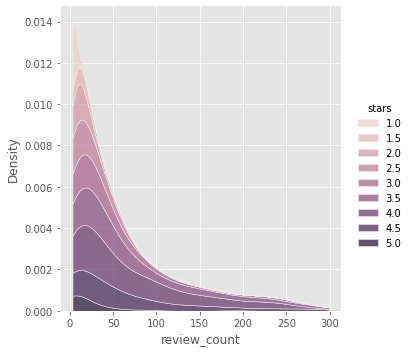

In [165]:
sns.displot(open[open.review_count <= 300], x="review_count", hue="stars", kind="kde", multiple="stack", cut=0)

##### Looks like 3.5 and 4 stars contribute more to the overall curve, let's double-check with a histogram

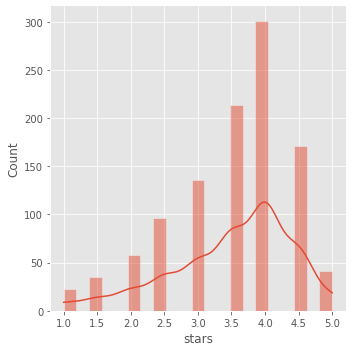

In [166]:
sns.displot(open, x='stars',kind='hist',kde=True)

##### Is there a significant diff between ratings of open vs closed restaurants?
According to the business data, no. But keep in mind that this data is all-time and the most recend period before closure might be different 

Text(0.5, 1.0, 'Open vs. Closed Restaurants Rating')

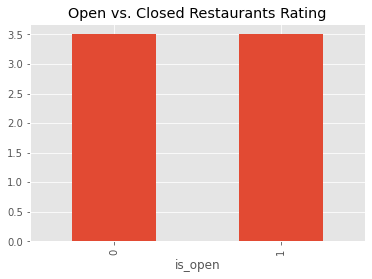

In [167]:
business.groupby('is_open')['stars'].median().plot.bar().set_title('Open vs. Closed Restaurants Rating')

##### Now take a look at check-in information

In [168]:
checkin.head(2)

,business_id,date
136,-23R9P2eG7VTc6DVLjFKzA,"2011-12-21 19:02:51, 2012-04-15 04:21:39, 2012-04-15 14:23:56, 2013-06-30 22:39:51, 2013-10-04 20:34:13, 2014-07-16 02:28:40"
624,-DU8jf5nA1_yaOqsKsLqmw,"2012-05-19 00:26:19, 2013-04-25 21:31:35, 2013-07-12 21:21:37, 2013-09-15 19:52:09, 2014-06-22 02:23:01, 2014-12-18 22:14:15, 2014-12-28 05:18:22, 2017-04-25 23:35:51"


##### Normalize dates: have each date in a separated row

In [169]:
checkin = checkin.assign(date=checkin.date.str.split(',')).explode('date')
checkin['date'] = pd.to_datetime(checkin.date)
checkin.head()

,business_id,date
136,-23R9P2eG7VTc6DVLjFKzA,2011-12-21 19:02:51
136,-23R9P2eG7VTc6DVLjFKzA,2012-04-15 04:21:39
136,-23R9P2eG7VTc6DVLjFKzA,2012-04-15 14:23:56
136,-23R9P2eG7VTc6DVLjFKzA,2013-06-30 22:39:51
136,-23R9P2eG7VTc6DVLjFKzA,2013-10-04 20:34:13


##### What are the checkin date ranges?

In [170]:
print(f"Checkins dates range from {checkin.date.min().strftime('%B %d, %Y')} to {checkin.date.max().strftime('%B %d, %Y')}\n")
print("Counts per year:")
pd.to_datetime(checkin.date).dt.to_period('Y').value_counts().sort_index()

Checkins dates range from January 16, 2010 to December 13, 2019

Counts per year:


2010     2884
2011    12887
2012    23469
2013    28989
2014    28905
2015    28717
2016    26548
2017    21195
2018    17618
2019    13724
Freq: A-DEC, Name: date, dtype: int64

##### We saw that 1,075 restaurants are open. How many have check-ins during the last year (2019) ?
Excluding Dec-2019, being a partial month



In [171]:
print(f"{checkin[checkin.date >= '2019-01-01'].business_id.nunique():,} restaurants have check-ins in 2019")
print()
check_per_rest = checkin[checkin.date >= '2019-01-01'].groupby('business_id').size()
print(check_per_rest.describe())
print()
pd.qcut(check_per_rest, 5).value_counts(dropna=False).sort_index()

803 restaurants have check-ins in 2019

count    803.000000
mean      17.090909
std       28.751805
min        1.000000
25%        2.000000
50%        7.000000
75%       20.000000
max      375.000000
dtype: float64



(0.999, 2.0]     219
(2.0, 4.0]       104
(4.0, 11.0]      168
(11.0, 25.6]     151
(25.6, 375.0]    161
dtype: int64

##### The median is 7 check-ins in 2019 per restaurant , and most restaurants have between 2 - 20
In order to check the number of checkins together with the number of reviews, let's look at reviews

##### Take a look at reviews information

In [172]:
review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27128 entries, 539 to 4020834
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   review_id    27128 non-null  object 
 1   user_id      27128 non-null  object 
 2   business_id  27128 non-null  object 
 3   stars        27128 non-null  float64
 4   useful       27128 non-null  int64  
 5   funny        27128 non-null  int64  
 6   cool         27128 non-null  int64  
 7   text         27128 non-null  object 
 8   date         27128 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 2.1+ MB


##### Looks good, no nulls,  but better to convert date to datetime type

In [173]:
review['date'] = pd.to_datetime(review.date)
pd.to_datetime(review.date).dt.to_period('Y').value_counts()

2018    14408
2019    12720
Freq: A-DEC, Name: date, dtype: int64

*** Note: the reviews where limited to the last 2 years during the subset selection process, to accomodate file size limitations

##### Review dates:

In [174]:
print(f"There are {len(review):,} reviews, ranging from\
 {min(pd.to_datetime(review.date)).strftime('%B %d, %Y')} to\
 {max(pd.to_datetime(review.date)).strftime('%B %d, %Y')}")

There are 27,128 reviews, ranging from January 01, 2018 to December 13, 2019


##### Now that we have both checkins and reviews data, let's check the trend of checkins and reviews numbers

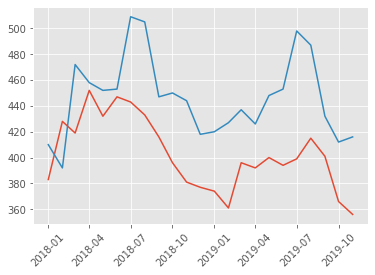

In [175]:
def year_trend(df):
    trend_df = df[(df.date >= '2018-01-01') & (df.date <= '2019-11-30')]
    trend_df = trend_df.groupby(trend_df.date.dt.strftime('%Y-%m'))['business_id'].nunique()
    trend_df.index = pd.to_datetime(trend_df.index,format='%Y-%m')
    plt.xticks(rotation = 45)
    plt.plot(trend_df)

year_trend(checkin)
year_trend(review)
plt.show()

##### We can see that there is a clear corrlation between checkin and reviews behaviour over time  

## Restaurant categories


##### Look for the categorical columns


In [176]:
business.select_dtypes(exclude=['float64', 'int64']).head(1)

,business_id,name,address,city,state,postal_code,attributes,categories,hours
41,98hyK2QEUeI8v2y0AghfZA,Pho Lee's Vietnamese Restaurant,"1541 E 38th St, Ste 101",Cleveland,OH,44114,"{'BusinessParking': 'None', 'Ambience': '{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': False, 'upscale': False, 'classy': False, 'casual': False}', 'BYOB': 'False', 'GoodForMeal': '{'dessert': False, 'latenight': False, 'lunch': False, 'dinner': False, 'brunch': False, 'breakfast': False}', 'Corkage': 'False', 'BusinessAcceptsCreditCards'...","Restaurants, Vietnamese, Soup","{'Monday': '11:0-20:0', 'Wednesday': '11:0-20:0', 'Thursday': '11:0-20:0', 'Friday': '11:0-20:0', 'Saturday': '11:0-20:0', 'Sunday': '11:0-20:0'}"


#### Organize business categories

##### Arrange them in columns

In [177]:
business.categories.head().str.split(',', expand=True)

,0,1,2,3,4,5,6,7,8,9,10,11
41,Restaurants,Vietnamese,Soup,None,None,None,None,None,None,None,None,None
49,Restaurants,Fast Food,Burgers,None,None,None,None,None,None,None,None,None
54,Shopping Centers,Food,Coffee & Tea,Cafes,Museums,Restaurants,Shopping,Local Flavor,Flowers & Gifts,Arts & Entertainment,Art Galleries,Florists
173,Diners,American (Traditional),Restaurants,None,None,None,None,None,None,None,None,None
623,Italian,Pizza,Restaurants,American (Traditional),None,None,None,None,None,None,None,None


##### Since the category values are mixed with no particular hierarchy...
let's collect all category values to decide which ones seem useful

In [178]:
categories = ' '.join(business.categories).split(',')
categories = pd.DataFrame(list(set([category.replace("\'|&", '').strip() for category in categories])))
categories.head()

,0
0,American (Traditional) Burgers
1,Steakhouses Seafood
2,Hookah Bars
3,Accessories
4,Imported Food


##### Check which are the most frequent values, and use them to build new features

In [179]:
business.categories.str.split(',\s+', expand=True).stack().value_counts()

Restaurants               1550
Food                       405
Nightlife                  330
Bars                       318
American (Traditional)     260
                          ... 
Airport Shuttles             1
Massage Therapy              1
Vitamins & Supplements       1
Personal Chefs               1
Specialty Schools            1
Length: 261, dtype: int64

##### build 3 new features = sub-categories: the restaurant region, the business type, and veggy/vegan food

##### Region = country-kitchen

In [180]:
values = ['American (Traditional)', 'American (New)', 'Italian', 'Chinese', 'Mexican', 'Mediterranean', 'Japanese', 'Asian Fusion', 'Thai', 'Indian', 'Middle Eastern', 'Greek', 'Latin American', 'French', 'Turkish', 'Korean', 'Caribbean', 'Southern', 'Vietnamese', 'Taiwanese', 'Pakistani', 'Szechuan']
conditions = list(map(business.categories.str.contains, values))
business['region'] = np.select(conditions, values, 'other')
business.region.value_counts()

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:2001: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



other             1052
Italian            107
Chinese            103
Mexican             75
Mediterranean       39
Japanese            31
Latin American      23
Middle Eastern      20
Asian Fusion        16
Indian              16
Southern            14
Thai                12
French              11
Greek                9
Vietnamese           8
Caribbean            8
Korean               5
Turkish              1
Name: region, dtype: int64

##### Restaurant type (bar, fast food, etc.)

In [181]:
values = ['Bars', 'Fast Food', 'Burgers', 'Cafes', 'Event Planning & Services', 'Delis', 'Caterers', 'Diners', 'Cocktail Bars', 'Bakeries', 'Sushi Bars', 'Sports Bars', 'Pubs', 'Steakhouses', 'Food Trucks', 'Lounges', 'Wine Bars', 'Arts & Entertainment', 'Beer Bar', 'Food Delivery Services', 'Grocery', 'Dive Bars', 'Gastropubs', 'Venues & Event Spaces']
conditions = list(map(business.categories.str.contains, values))
business['business_type'] = np.select(conditions, values, 'other')
business.business_type.value_counts()

other                        697
Bars                         370
Fast Food                    163
Delis                         61
Cafes                         49
Bakeries                      47
Burgers                       44
Event Planning & Services     42
Diners                        34
Arts & Entertainment          12
Steakhouses                   11
Food Trucks                    8
Grocery                        5
Food Delivery Services         4
Gastropubs                     3
Name: business_type, dtype: int64

##### Vegeterian and Vegan

In [182]:
conditions = list(map(business.categories.str.lower().str.contains, ['veg']))
business['veggy'] = np.select(conditions, ['veg'], 'other')
business.veggy.value_counts()

other    1515
veg        35
Name: veggy, dtype: int64

##### Which country-style restaurant are more popular? 

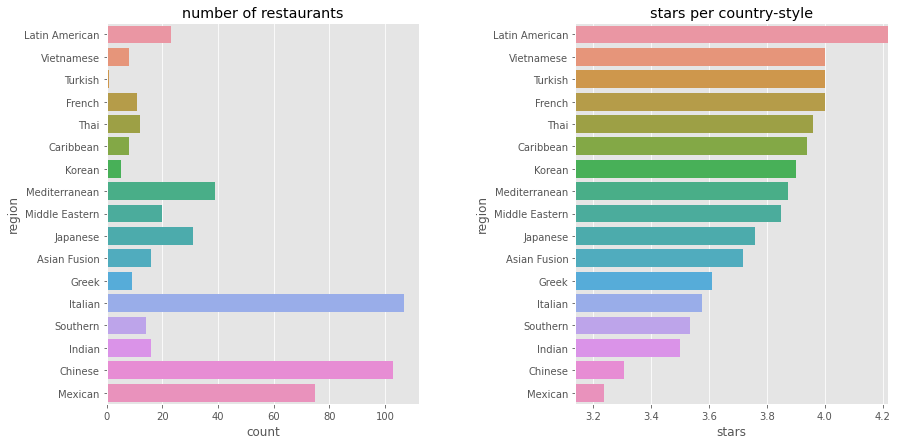

In [183]:
regions = business[business.region != 'other'][['region', 'stars']]
reg = regions.groupby('region')['stars'].mean().reset_index(name='stars').sort_values(by='stars', ascending=False)
fig, ax = plt.subplots(1,2,figsize=(14,7))
plt.subplots_adjust(wspace=0.5)
plt.xlim(reg.stars.min()-0.1, reg.stars.max())
t = sns.countplot(y='region', data=regions, ax=ax[0], order=reg.region).set_title('number of restaurants')
t = sns.barplot(x=reg.stars, y=reg.region, orient='h', ax=ax[1]).set_title('stars per country-style')

##### Latin american restaurants are top rated, but there aren't so many<br> Maxican style is the opposite - many restaurants, but have the lowest ratings<br> Italians are the largest in quantity, but rated below average 

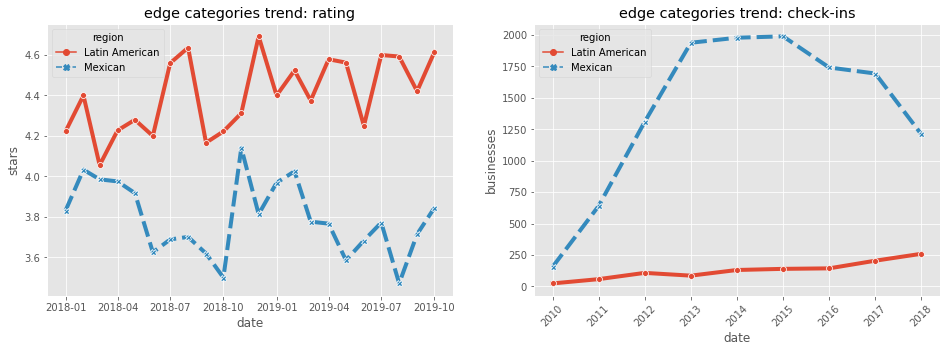

In [184]:
edge_categ = business[business.region.isin(['Mexican', 'Latin American'])][['business_id', 'region']]
rev_categ = review[['business_id', 'date', 'stars']][review.date <= '2019-10-30'].merge(edge_categ, on='business_id', how='inner')
rev_categ = rev_categ.groupby([rev_categ.region, rev_categ.date.dt.strftime('%Y-%m')])['stars'].mean().reset_index()
rev_categ['date'] = pd.to_datetime(rev_categ.date,format='%Y-%m')

chk_categ = checkin[['business_id', 'date']][checkin.date <= '2018-12-31'].merge(edge_categ, on='business_id', how='inner')
chk_categ = chk_categ.groupby([chk_categ.region, chk_categ.date.dt.strftime('%Y')]).size().reset_index(name="businesses")
chk_categ['date'] = pd.to_datetime(chk_categ.date,format='%Y')

fig, ax = plt.subplots(1,2,figsize=(16,5))
plt.subplots_adjust(wspace=0.2)
t = sns.lineplot(data=rev_categ, x="date", y="stars", hue="region", ax=ax[0], style="region", markers=True, linewidth=4)\
.set_title("edge categories trend: rating")
t = plt.xticks(rotation = 45)
t = sns.lineplot(data=chk_categ, x="date", y="businesses", hue="region", ax=ax[1], style="region", markers=True, linewidth=4)\
.set_title("edge categories trend: check-ins")
t = plt.xticks(rotation = 45)

##### Looks like the latin-american segment is trending nicely, mexican checkins slows down since 2016.
Look at their distribution:    

Text(0.5, 0, 'Mexican')

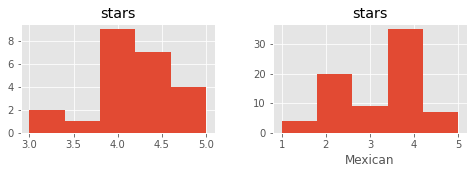

In [185]:
fig, axes = plt.subplots(1, 2, figsize=(8,2))
ax = business[business.region == 'Latin American'].hist('stars', bins=5, ax=axes[0])
plt.xlabel('Latin American')
ax = business[business.region == 'Mexican'].hist('stars', bins=5, ax=axes[1])
plt.xlabel('Mexican')

Let's read 2 examples of reviews from these top and lowest restaurants:

In [186]:
lowest = business[business.region == 'Mexican'].sort_values(by='stars').head(1).business_id.iloc[0]
printbold("**lowest rated mexican review**")
print(review[review.business_id == lowest].text.iloc[0])
print()
top = business[business.region == 'Latin American'].sort_values(by='stars', ascending=False).head(1).business_id.iloc[0]
printbold("**top rated latin American review**")
print(review[review.business_id == top].text.iloc[0])

**lowest rated mexican review**

Wait in drive thru was very long. When I received my burrito the rice was Barely cooked so I ended up throwing the whole burrito away. What a waste of money!



**top rated latin American review**

The best empanada I've ever had!  Small family run restaurant with excellent service.  The food is amazing!  We got the tostones and tropichop.  Had the guava-chipotle sauce to add to everything.  The owner is incredibly sweet-she is also an artist-you can see her work in the restaurant.  She came out to see how everything was and treated us to complimentary tres leches! Will definitely go back when I'm in Cleveland.


## Restaurant attributes

#### Flatten complex objects

##### Handle missing values, clean special unicode u' symbols



In [187]:
business['attributes'] = business.attributes.apply(lambda x: {} if x is None else x)
business['attributes'] = business.attributes.apply(lambda x: ast.literal_eval(json.dumps(x).replace("u\'", "")))

##### Start with *attributes* and business hours

In [188]:
business_data = business.drop(['attributes', 'hours'], axis=1)
flat_cols = flat_table.normalize(business[['attributes', 'hours']])
business = pd.concat([business_data.reset_index(drop=True), flat_cols], axis=1)
business.columns = [x[len('attributes.'):] if x.startswith('attributes.') else x for x in business.columns]
business.columns = [x[len('hours.'):] if x.startswith('hours.') else x for x in business.columns]

In [189]:
business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1550 entries, 0 to 1549
Data columns (total 59 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   business_id                 1550 non-null   object 
 1   name                        1550 non-null   object 
 2   address                     1550 non-null   object 
 3   city                        1550 non-null   object 
 4   state                       1550 non-null   object 
 5   postal_code                 1550 non-null   object 
 6   latitude                    1550 non-null   float64
 7   longitude                   1550 non-null   float64
 8   stars                       1550 non-null   float64
 9   review_count                1550 non-null   int64  
 10  is_open                     1550 non-null   int64  
 11  categories                  1550 non-null   object 
 12  region                      1550 non-null   object 
 13  business_type               1550 

##### Flatten additional attributes

In [190]:
def flatten_col(df, col):
    df[col] = df[col].apply(lambda x: '{}' if len(str(x))<=5 else x)
    df[col] = df[col].replace("\'", "\"")
    df[col] = df[col].apply(ast.literal_eval)
    df = pd.concat([df.drop([col], axis=1).reset_index(drop=True), pd.json_normalize(df[col])], axis=1)
    return df


In [191]:
business = flatten_col(business, 'GoodForMeal')
business = flatten_col(business, 'Ambience')
business = flatten_col(business, 'BusinessParking')
business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1550 entries, 0 to 1549
Data columns (total 76 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   business_id                 1550 non-null   object 
 1   name                        1550 non-null   object 
 2   address                     1550 non-null   object 
 3   city                        1550 non-null   object 
 4   state                       1550 non-null   object 
 5   postal_code                 1550 non-null   object 
 6   latitude                    1550 non-null   float64
 7   longitude                   1550 non-null   float64
 8   stars                       1550 non-null   float64
 9   review_count                1550 non-null   int64  
 10  is_open                     1550 non-null   int64  
 11  categories                  1550 non-null   object 
 12  region                      1550 non-null   object 
 13  business_type               1550 

##### Drop columns containing mostly null values 

In [192]:
business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1550 entries, 0 to 1549
Data columns (total 76 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   business_id                 1550 non-null   object 
 1   name                        1550 non-null   object 
 2   address                     1550 non-null   object 
 3   city                        1550 non-null   object 
 4   state                       1550 non-null   object 
 5   postal_code                 1550 non-null   object 
 6   latitude                    1550 non-null   float64
 7   longitude                   1550 non-null   float64
 8   stars                       1550 non-null   float64
 9   review_count                1550 non-null   int64  
 10  is_open                     1550 non-null   int64  
 11  categories                  1550 non-null   object 
 12  region                      1550 non-null   object 
 13  business_type               1550 

In [193]:
drop_cols = ['AcceptsInsurance', 'AgesAllowed', 'DietaryRestrictions', 'BYOBCorkage', 'Corkage', 'BYOB']
business.drop(drop_cols, axis=1, inplace=True)

##### Check the new attributes which were added during flattening
Check string and float columns which might need a conversion to boolean

In [194]:
print('string:')
for col in business.columns:
    if isinstance(business[col][0], str):
        print(col)
print()
print('float:')
for col in business.columns:
    if isinstance(business[col][0], float):
        print(col)

string:
business_id
name
address
city
state
postal_code
categories
region
business_type
veggy
RestaurantsDelivery
Caters
RestaurantsTakeOut
WheelchairAccessible
RestaurantsTableService
WiFi
OutdoorSeating
HasTV
Alcohol
BikeParking
BusinessAcceptsCreditCards
Sunday
Saturday
Friday
Thursday
Wednesday
Monday

float:
latitude
longitude
stars
ByAppointmentOnly
BusinessAcceptsBitcoin
DogsAllowed
DriveThru
BestNights
Smoking
Music
GoodForDancing
CoatCheck
HappyHour
RestaurantsGoodForGroups
RestaurantsReservations
RestaurantsPriceRange2
RestaurantsAttire
NoiseLevel
GoodForKids
Tuesday
garage
street
validated
lot
valet


In [195]:
str_bool = ['RestaurantsDelivery', 'Caters', 'RestaurantsTakeOut', 'WheelchairAccessible',
            'RestaurantsTableService', 'OutdoorSeating', 'HasTV', 'BikeParking', 'BusinessAcceptsCreditCards']
for col in str_bool:
    business[col] = business[col].apply(lambda x: bool(strtobool(str(x))) if x in ['True', 'False'] else None)
# also keep track of the additional columns which are boolean by nature
float_bool = ['ByAppointmentOnly', 'BusinessAcceptsBitcoin', 'DogsAllowed', 'DriveThru', 'GoodForDancing', 'CoatCheck',
            'HappyHour', 'RestaurantsGoodForGroups', 'RestaurantsReservations', 'GoodForKids',
            'garage', 'street', 'validated', 'lot', 'valet']


##### drop the "not-so-interesting" boolean columns having less than 100 True values

In [196]:
val_count = business[str_bool].apply(pd.Series.value_counts).T[True]
drop_cols = val_count.index[val_count<100].to_list()
val_count = business[float_bool].apply(pd.Series.value_counts).T['True']
drop_cols = drop_cols + val_count.index[val_count<100].to_list()
drop_cols

['ByAppointmentOnly',
 'BusinessAcceptsBitcoin',
 'DogsAllowed',
 'DriveThru',
 'GoodForDancing',
 'CoatCheck']

In [197]:
# drop these columns
business.drop(drop_cols, axis=1, inplace=True)
business.drop('index', axis=1, inplace=True)

##### Clean redundant quotes
for example, let's look at WiFi

In [198]:
business.WiFi.value_counts()

free'     381
no'       317
'no'      157
'free'    133
paid'       7
'paid'      3
None        1
Name: WiFi, dtype: int64

In [199]:
for col in ['WiFi', 'Alcohol', 'Smoking', 'RestaurantsAttire', 'NoiseLevel']:
    business[col] = business[col].str.replace("\'", "")

business.WiFi.value_counts()

free    514
no      474
paid     10
None      1
Name: WiFi, dtype: int64

#### Look into restaurants opening days

In [200]:
weekdays=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
business.loc[business.is_open == 1, weekdays].head()

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,11:0-20:0,NaN,11:0-20:0,11:0-20:0,11:0-20:0,11:0-20:0,11:0-20:0
1,10:0-3:0,10:0-3:0,10:0-3:0,10:0-3:0,10:0-3:0,10:0-3:0,10:0-3:0
2,0:0-0:0,0:0-0:0,0:0-0:0,0:0-0:0,0:0-0:0,0:0-0:0,0:0-0:0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,7:0-15:0,7:0-15:0,7:0-15:0,7:0-15:0,7:0-15:0,NaN,NaN


* Cleanse the opening-hours columns
* Filter out closed businesses
* Check on which days businesses are open

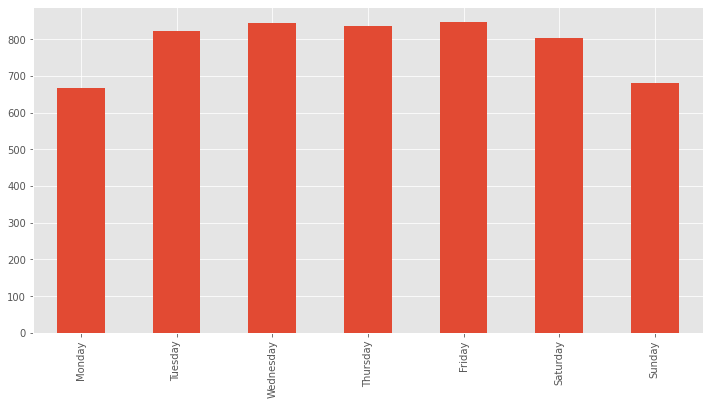

In [201]:
plt.figure(figsize=(12,6))
business[weekdays] = business[weekdays].replace({'0:0-0:0':np.nan})
opendays = business.loc[business.is_open == 1, weekdays].notnull()
opendays.T.sum(axis=1).plot(kind="bar")
# plt.title('Open businesses per day')

* Looks like off-time is Sun-Mon, not Sat-Sun 
* Check out percentages, too: only ~ 62% of the open restaurants work on Mondays

In [202]:
open_closed = opendays.replace([True, False], ['Open', 'Closed']) 
open_closed.apply(lambda x: x.value_counts(normalize=True))

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Open,0.619535,0.763721,0.784186,0.776744,0.786977,0.746977,0.633488
Closed,0.380465,0.236279,0.215814,0.223256,0.213023,0.253023,0.366512


# Users rating distributon

In [203]:
# explain about the review dataset...
review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
539,LSPBfreF-ma3GbqEunb9iA,xEKAb9TGx4aOGbHXSaCmDQ,K74HYkFjYwhEpJt8HTOxnQ,5.0,1,1,1,"We had an incredible time. The food and atmosphere was so good. Linda, our waitress, was the best. Thank you Linda!",2018-04-15 15:46:14
972,48YT48A1T7Z0W2d4G5h-8A,9AXgrU2M4baavs31OjW-XA,eoJfl5vG7X87QhcKb0nt5Q,5.0,0,0,0,"First visit here! Won't be the last!! Bier was Amazing, food was Amazing and service (Beth) was Amazing ++! Great fun environment and felt very authentic.",2018-10-04 18:04:02
1152,NBYVf57gR1UdkUznwXBN8Q,RQgoeHEU4xVOIsKSztkiEQ,K74HYkFjYwhEpJt8HTOxnQ,5.0,0,0,0,My favorite go to every time I'm in Cleveland. The cold smoked filet is outstanding. Do net let the location scare you. A true gem,2018-07-26 11:41:24
1238,zbmdJsCWvbd9IUAemNvCdA,6rjLhfryUZgxpxPfMiH_8w,t7b_86s_Q__P35H9NXedhw,5.0,1,0,0,"Best gyros ! Great portions and their fries are wonderful ! Employees very friendly and polite. We will be going back every chance we get. I've only had one gyro better and that was at the stand at Westside Market, but these are close to a tie. Love them !",2018-04-04 02:53:02
1662,0y-wiv-076zJW4xFXxi4mg,hlcHT9yysI-W7DBWMtAt9A,1gQrMs-I8oKg2p-iRxznzQ,5.0,1,1,1,"The fried chicken is perfect- very crispy and the flavor of the coating is great. The bbq sauce on the side is just the right amount of sweet. The collard greens and mac and cheese that came with my dish (the ""Late Night"") were awesome as well. The pre-meal biscuits with jam and rosemary butter was 10/10. \n\nI really enjoyed being in a restaurant where the music also isn't loud and you don't ...",2018-04-15 13:51:13


# proportion of negative reviews (stars<3) and positive reviews(stars>3) 
stars=3 --> neutral review

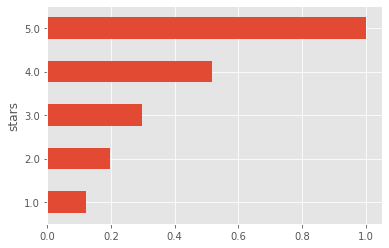

In [204]:
stars_cumsum=((review.groupby('stars').size())/review.shape[0]).cumsum()
stars_cumsum.plot.barh()

In [205]:
stars_cumsum

stars
1.0    0.122715
2.0    0.197361
3.0    0.298990
4.0    0.517436
5.0    1.000000
dtype: float64

- negative reviews(stars<3) are 20% of the total reviews
- positive reviews(stars>3) are 70% of the total reviews

# check which business had the highest number of negative reviews


In [206]:
negative_reviews=review[review.stars<3]
negative_id=negative_reviews.groupby('business_id').stars.count().sort_values(ascending=False).index[0]
print(f'the business with the highest number of negative reviews is: {business[business.business_id==negative_id].name.iloc[0]}, it had 92 negative reviews')
business[business.business_id==negative_id]

the business with the highest number of negative reviews is: Margaritaville - Cleveland, it had 92 negative reviews


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,region,business_type,veggy,BestNights,Smoking,Music,HappyHour,RestaurantsGoodForGroups,RestaurantsReservations,RestaurantsPriceRange2,RestaurantsAttire,NoiseLevel,GoodForKids,RestaurantsDelivery,Caters,RestaurantsTakeOut,WheelchairAccessible,RestaurantsTableService,WiFi,OutdoorSeating,HasTV,Alcohol,BikeParking,BusinessAcceptsCreditCards,Tuesday,Sunday,Saturday,Friday,Thursday,Wednesday,Monday,dessert,latenight,lunch,dinner,brunch,breakfast,touristy,hipster,romantic,divey,intimate,trendy,upscale,classy,casual,garage,street,validated,lot,valet
639,TaEASKZil0TT7CAzyqFUgw,Margaritaville - Cleveland,1150 Front Ave,Cleveland,OH,44113,41.500625,-81.706467,2.5,256,1,"Restaurants, Bars, American (Traditional), Nightlife",other,Bars,other,"{'monday': False, 'tuesday': False, 'friday': True, 'wednesday': False, 'thursday': False, 'sunday': True, 'saturday': True}",no,"{'dj': False, 'background_music': False, 'no_music': False, 'jukebox': False, 'live': True, 'video': False, 'karaoke': False}",True,True,False,2,casual,loud,True,True,None,True,None,True,free,True,True,full_bar,True,True,11:0-23:0,11:0-23:0,11:0-1:0,11:0-1:0,11:0-23:0,11:0-23:0,11:0-23:0,False,False,True,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False


# business with the highest number of positive reviews

### we define a positive review as a review of stars>3

In [207]:
positive_reviews=review[review.stars>3]
positive_id=positive_reviews.groupby('business_id').stars.count().sort_values(ascending=False).index[0]
print(f'the business with the highest number of positive reviews is: {business[business.business_id==positive_id].name.iloc[0]}, it had 424 positive reviews')
business[business.business_id==positive_id]


the business with the highest number of positive reviews is: Townhall, it had 424 positive reviews


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,region,business_type,veggy,BestNights,Smoking,Music,HappyHour,RestaurantsGoodForGroups,RestaurantsReservations,RestaurantsPriceRange2,RestaurantsAttire,NoiseLevel,GoodForKids,RestaurantsDelivery,Caters,RestaurantsTakeOut,WheelchairAccessible,RestaurantsTableService,WiFi,OutdoorSeating,HasTV,Alcohol,BikeParking,BusinessAcceptsCreditCards,Tuesday,Sunday,Saturday,Friday,Thursday,Wednesday,Monday,dessert,latenight,lunch,dinner,brunch,breakfast,touristy,hipster,romantic,divey,intimate,trendy,upscale,classy,casual,garage,street,validated,lot,valet
338,LNsZJP6jZ11e0tDljOLPiQ,Townhall,1909 W 25th St,Cleveland,OH,44113,41.485492,-81.703914,4.0,1372,1,"Food, American (New), Salad, Sandwiches, Beer, Wine & Spirits, Restaurants, Juice Bars & Smoothies, Bars, Nightlife, Beer Bar",other,Bars,other,"{'monday': True, 'tuesday': False, 'friday': False, 'wednesday': True, 'thursday': True, 'sunday': False, 'saturday': False}",no,"{'dj': False, 'background_music': False, 'no_music': False, 'jukebox': False, 'live': False, 'video': False, 'karaoke': False}",True,True,False,2,casual,loud,True,True,True,True,None,True,free,True,True,full_bar,True,True,11:0-2:0,9:0-2:0,9:0-2:0,11:0-2:0,11:0-2:0,11:0-2:0,11:0-2:0,False,False,True,True,True,False,False,False,False,False,False,True,False,True,True,False,True,False,True,True


# is there a relation between specific words and rating?

### to answer that we will compute the proportion of the words that have positive connotations, negative connotations or are neutral in highly rated restaurant vs low-rated restaurant
###we will use the afinn package- which is a lexicon that gives scores to words,  scores<0  --> negative, scores=0 --> neutral, socres>0 --> positive

In [208]:
afinn = Afinn(language='en')

In [209]:
#add a review_score to the text reviews in each set of businesess:
positive_reviews['review_score']=positive_reviews.text.apply(afinn.score)
negative_reviews['review_score']=negative_reviews.text.apply(afinn.score)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### highly rated restaurants reviews score:

In [210]:
positive_reviews.loc[:,positive_reviews.columns.str.contains("text|review_score")].sort_values(by='review_score',ascending=False)

,text,review_score
3692770,"Considering that I've visited the Urban Farmer quite a few times over my many nights in the Westin, I think it's about time that I add a review. \n\nThe cheese and charcuterie here is fantastic. The boards that they create have a great variety of cheeses and meats, but I've also seen them wheel around a cheese cart where you can build your own board that is priced by the ounce. The server is f...",105.0
1101136,"Was pleasantly surprised by the Butcher and the Brewer! I came in with a party of about 10 on a weeknight and we were able to be seated immediately at a long table. I love the vibe of this place--industrial but chic. Impressive food but also maintains that casual bar feel. Our waitress was friendly and informed us off the bat that their plates are designed to be shared. As a result, we ordered...",100.0
1526281,"I am EXCITED to welcome this unique addition to the Asiatown food scene. I'm all about the new and exciting, but at the same time, when I'm trying out a new restaurant, I think about how it stacks up to other favorites I have in the area, and whether it's worth revisiting. One question I ask myself is whether I'd visit this new restaurant over an old favorite, and given that I have a LOT of ol...",97.0
3089028,"So due to this being my go-to bar and being friends with half the staff, I always thought it was unfair for me to leave a review, but you know what. I love this place. \nThe servers are all super fun and full energy. I dont often sit at a table but when I do it's always fun, when my family joins me they all greet them as if they were their family and my family appreciates that. This is my Chee...",93.0
497830,"Alright, I've had five meals here in a week so I have to rate them highly. I give them 4.5 - 5 stars. \n\nFirst visit was for the Cleveland Supper Club where about a dozen of us enjoyed dining in. They do not take reservations but were more than happy to help me push a couple tables together for our group and appreciated my calling to let them know in advance. I like the modern industrial dec...",88.0
...,...,...
1122564,"Bad Tom is not bad; in fact, it's very good.\n\nOur first visit on a Wednesday consisted of us, and the bartender AJ. AJ was a little bored because you aren't frequenting taproom. Yes, you. Not us, because we've at least been. It's you that's the source of AJ's boredom. \n\nBut I get it. Would know this this was a taproom featuring, you guessed it, beer, if someone hadn't told you? That...",-11.0
2879462,Dank ass tree\n\nCold ass beer\n\nGood ass food\n\nNice ass patio\n\nGreat ass location\n\nSolid ass beer selection,-13.0
1476024,"Eight of us came in for the 100th time. We never once had a problem at Barrio until this blonde bitch served us. I don't know what her name is but she worked on Tuesday July 23, 19 at night at Tremont. I've never felt so unwelcomed. We were wondering why she was being rude as fuck until the end when she said gratuity was added to the check. Makes sense now. Barrio 4 stars that bitch 0 stars.",-18.0
2190007,"Brown bomber shit, brown shit, black shit green shit, purple shit, ice cream shit, corn shit",-28.0


### low rated restaurant review score:

In [211]:
negative_reviews.loc[:,negative_reviews.columns.str.contains("text|review_score")].sort_values(by='review_score',ascending=False)

,text,review_score
1495882,"Starting out at BOLD, this establishment appeared high end and quite attractive from a menu and ambiance perspective. The menu was innovate and fun, and over all service starting at the host stand was impeccable - however the likeness ended there - mostly. \n\nWe ordered the blue point oysters, the Z Shrimp Tacos and the roasted tomato bisque to start out our meal. Overall, the appetizer porti...",65.0
642709,"My friend loves BBQ and she really wanted to check this place out. I love pulled pork, but it takes a lot to wow me in the BBQ space. The restaurant is easy to find. The inside is small, but can accommodate a large group if reserved in advance. The menu is easy to navigate. This is definitely a family owned business, as the cook's daughter and everyone in between was helping out. With the exce...",65.0
3525721,"We went last night, first time in a number of years. This is an old place -- I am pretty sure it was around when I was in high school and I am not a youngster. I've eaten here any number of times over the past 30+ years. It is in new hands or some change in management. Quality has really dropped. Prices have literally doubled, vs other local Chinese places -- they now charge $13 (!!!) for a co...",44.0
3936732,"TLDR; is not a ""good place for dinner,"" 2/3 of the venue was closed for private events, and menu was limited. Is probably a good place for late night.\n\nI had to give it 2 stars bc I think 3 stars is a bit generous, but the food was pretty good and so were the drinks. My chicken sandwich was quite good and crispy, the chorizo fries we ordered were good and a very generous size, and my date's ...",44.0
3080744,"Pretty disappointed about my visit to Jack Flaps. I had such high hopes! The month prior, I was up in Cleveland (where I'm originally from) and my sister made brunch reservations for us at La Petite Triangle Cafe in Ohio City. We had such a great meal and experience that I told my sister I wanted to do it all over again; although I wanted to keep venturing out to different, hot brunch location...",43.0
...,...,...
998183,"This is the worlds worst McDonald's. I go to CSU so unfortunately this is the closest McDonald's and unfortunately I really like the their $1 Carmel iced coffee and get it everyday. I've had some of the worst encounters with the workers here than I ever have anywhere else. For going here every single day, I have problems with these employees 9/10 times that I go. These employees are the scum ...",-35.0
1417354,The worst. The staff is completely incompetent and has no idea what they are doing. Worst pizza experience ever. Just avoid. These people have no idea how to interact with humans. Completely disrespectful and the worst service you could ever anticipate. Do not purchase food from this establishment. Avoid at all costs. Do not make the same mistake that we did. They spit in food & treat yo...,-37.0
696098,"I NEVER give 1 star reviews, you can check my cred. Out of my current 223 reviews, only 2 of them are 1 star. That should just prove how truly bad this experience was. If it wasn't for my Benihana Club $30 birthday reward, I wouldn't have even stayed to endure the pain and suffering that was this visit. \n\nFirst off, they were extremely understaffed. With both servers and grill chefs. We had ...",-38.0
2270203,"last night experience was horrible!\nI received poor service, rude attitude from the staff, delayed order, lies and more,I'm traumatized!\nI called the restaurant to placed an order for takeout, been told it will be ready in 20 min.I agreed, told them I'm on my way.\nI asked about the cost, been told that they don't know but promised to call me back! \nI arrived after 23 min, no one called me...",-41.0


### Distribution of review scores in the high rated restaurants vs the low rated restaurants:

Text(0.5, 1.0, 'distribution of review score in low rated restaurants')

<Figure size 864x1440 with 0 Axes>

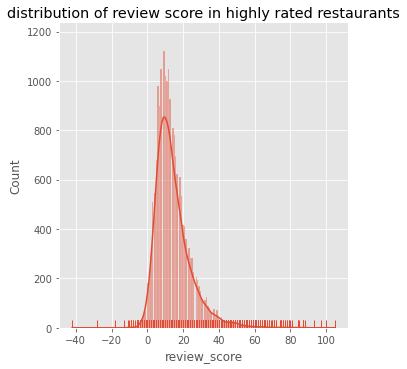

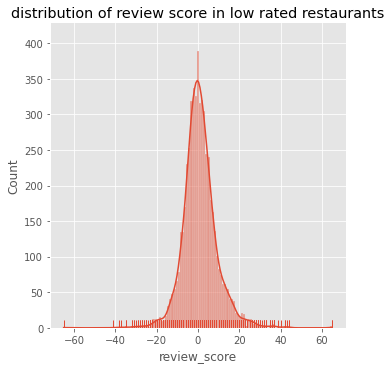

In [212]:
plt.figure(figsize=(12,20))
sns.displot(data=positive_reviews,x='review_score',kind='hist',kde=True,rug=True)
plt.title("distribution of review score in highly rated restaurants")
sns.displot(data=negative_reviews,x='review_score',kind='hist',kde=True,rug=True)
plt.title("distribution of review score in low rated restaurants")

- we can see that the median score is higher in the highly rated restaurants ,plus the max score is higher, the min score is lower

In [213]:
positive_reviews.review_score.describe()

count    19017.000000
mean        14.436504
std         10.132913
min        -42.000000
25%          8.000000
50%         12.000000
75%         19.000000
max        105.000000
Name: review_score, dtype: float64

In [214]:
negative_reviews.review_score.describe()

count    5354.000000
mean        0.965820
std         8.243319
min       -65.000000
25%        -4.000000
50%         0.000000
75%         5.000000
max        65.000000
Name: review_score, dtype: float64

# Now let us check the most common words in those reviews of highly rated vs low rated restaurants

### we will do that by generating a word cloud - most frequent words in a large text

In [215]:
nltk.download('stopwords') 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### start with highly rated restaurants

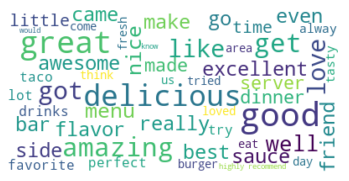

In [216]:
# generqate a large text of all the reviews 
pos_text=" ".join(review for review in positive_reviews.text)
# create a list of words that are not informative that we don't want to include the wordcloud
# Default English stopwords list:
stop_words=stopwords.words('english')
# add some words that are not informative based on the wordclouds that we get:
stop_words.extend(['Cleveland','pizza','ordered','place','order','meal','also','drink','restaurant','one','food','beer','table'])
wordcloud=WordCloud(stopwords=stop_words,max_font_size=40, max_words=50, background_color="white").generate(pos_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### we can clearly see how common positive words are in the reviews of highly rated restaurants:
- good, great, amazing, nice, delicious, love, awesome, favorite, excellent

### generate word cloud for low rated restaurants




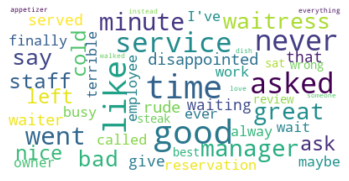

In [217]:
# generqate a large text of all the reviews in the low rated restaurants
neg_text=" ".join(review for review in negative_reviews.text)
# create a stopwords list
stop_words2=stop_words
stop_words2.extend(['came','know','get','even','Would','really','got','know','menu','people','server','friend','eat','back','come','told','need','could','drinks',
'going','first','chicken','two','want','way',"I'm",'location','thing','us','still','sauce','bar','check','water','well','though','take','salad','go','much','made','meat','wanted','day','hour','took','around',
'sandwich','tried','make','see','put','since','bartender','said','However','flavor','another','think','burger','since'
,'dinner','something','better','try','right','sure','customer','price','nothing','little','tell',"Ive",'that','ok','taste','arrived','cheese','side','half','experience'])
# Create and generate a word cloud image:
wordcloud=WordCloud(stopwords=stop_words2,max_font_size=40, max_words=50, background_color="white").generate(neg_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

- we can see a lot of reference to staff , quality and time of service: manager, staff, waiter,waitress, time ,waiting, finally, wrong
- we can see bad words such as : bad, disappointed,rude,terrible
- we can also see some good words: great, good

# distribution of labesl: cool, funny, useful values as a function of rating

Text(0.5, 1.0, 'low rated reviews labels distribution')

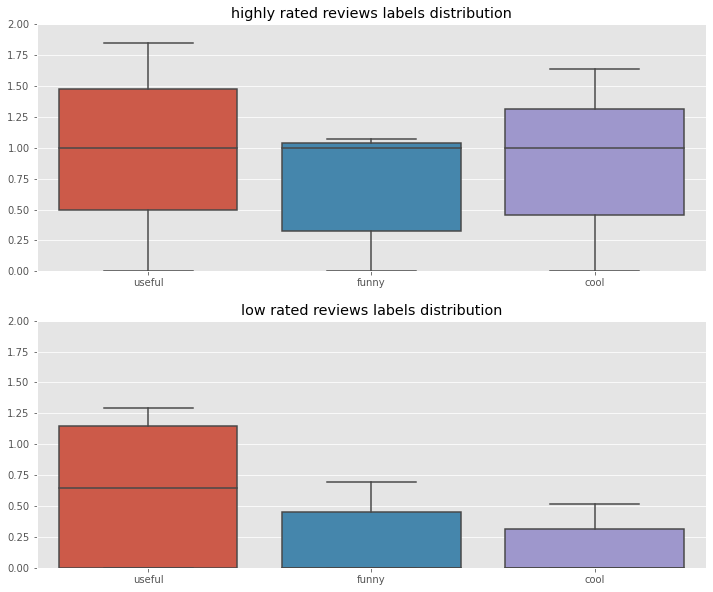

In [218]:
df=positive_reviews.describe().drop(['stars','review_score'],axis=1).drop('count',axis=0)
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
sns.boxplot(data=df)
plt.ylim([0,2])
plt.title('highly rated reviews labels distribution')
plt.subplot(2,1,2)
df2=negative_reviews.describe().drop(['stars','review_score'],axis=1).drop('count',axis=0)
sns.boxplot(data=df2)
plt.ylim([0,2])
plt.title('low rated reviews labels distribution')

- highly rated reviews have a higher mean,median of useful,funny,cool labels
- they have a larger max (larger outliers)

# Restaurant user rating as a function of restaurant overload
### we want to find the relation between user ratings for restaurants in a month with a high number of checkins vs a month with low number of checkins  


In [219]:
checkin.head()

,business_id,date
136,-23R9P2eG7VTc6DVLjFKzA,2011-12-21 19:02:51
136,-23R9P2eG7VTc6DVLjFKzA,2012-04-15 04:21:39
136,-23R9P2eG7VTc6DVLjFKzA,2012-04-15 14:23:56
136,-23R9P2eG7VTc6DVLjFKzA,2013-06-30 22:39:51
136,-23R9P2eG7VTc6DVLjFKzA,2013-10-04 20:34:13


### to prevent the possibility of an alternative explanation to the reviews, we will work with restaurants with 3 stars - which we defined as a neutral score.

In [220]:
three_stars_restaurants=business[business.stars==3]
three_stars_checkin=checkin[checkin.business_id.isin(three_stars_restaurants.business_id)]
three_stars_checkin.head()


,business_id,date
1212,-QjnuSMIAJhcwOc-8BqalA,2015-03-24 00:55:07
1212,-QjnuSMIAJhcwOc-8BqalA,2015-04-07 01:08:16
1212,-QjnuSMIAJhcwOc-8BqalA,2015-10-07 18:21:45
1212,-QjnuSMIAJhcwOc-8BqalA,2016-01-14 05:48:50
1212,-QjnuSMIAJhcwOc-8BqalA,2016-11-01 19:28:51


### dates of checkins in these restaurants as a dataframe which consists of datetime objects

In [221]:
dates=three_stars_checkin.date.apply(lambda x:pd.to_datetime(pd.Series(x)))
dates.head()

,0
1212,2015-03-24 00:55:07
1212,2015-04-07 01:08:16
1212,2015-10-07 18:21:45
1212,2016-01-14 05:48:50
1212,2016-11-01 19:28:51


### monthly number of checkins over the years in those restaurants

In [222]:
dates.apply(lambda x:x.dt.month.value_counts(),axis=1).sum()

1     1541.0
2     1600.0
3     1870.0
4     1863.0
5     2071.0
6     2202.0
7     2254.0
8     2298.0
9     1986.0
10    1970.0
11    1955.0
12    1801.0
dtype: float64

### most loaded month - august(8) - 2298 checkins

In [223]:
dates.apply(lambda x:x.dt.month.value_counts(),axis=1).sum().sort_values(ascending=False).head(1)

8    2298.0
dtype: float64

### the least overloaded month was january(1) - it had 1541 checkins

In [224]:
dates.apply(lambda x:x.dt.month.value_counts(),axis=1).sum().sort_values(ascending=True).head(1)

1    1541.0
dtype: float64

### now we move over to the review dataset

In [225]:
review['date']=pd.to_datetime(review['date'])
review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
539,LSPBfreF-ma3GbqEunb9iA,xEKAb9TGx4aOGbHXSaCmDQ,K74HYkFjYwhEpJt8HTOxnQ,5.0,1,1,1,"We had an incredible time. The food and atmosphere was so good. Linda, our waitress, was the best. Thank you Linda!",2018-04-15 15:46:14
972,48YT48A1T7Z0W2d4G5h-8A,9AXgrU2M4baavs31OjW-XA,eoJfl5vG7X87QhcKb0nt5Q,5.0,0,0,0,"First visit here! Won't be the last!! Bier was Amazing, food was Amazing and service (Beth) was Amazing ++! Great fun environment and felt very authentic.",2018-10-04 18:04:02
1152,NBYVf57gR1UdkUznwXBN8Q,RQgoeHEU4xVOIsKSztkiEQ,K74HYkFjYwhEpJt8HTOxnQ,5.0,0,0,0,My favorite go to every time I'm in Cleveland. The cold smoked filet is outstanding. Do net let the location scare you. A true gem,2018-07-26 11:41:24
1238,zbmdJsCWvbd9IUAemNvCdA,6rjLhfryUZgxpxPfMiH_8w,t7b_86s_Q__P35H9NXedhw,5.0,1,0,0,"Best gyros ! Great portions and their fries are wonderful ! Employees very friendly and polite. We will be going back every chance we get. I've only had one gyro better and that was at the stand at Westside Market, but these are close to a tie. Love them !",2018-04-04 02:53:02
1662,0y-wiv-076zJW4xFXxi4mg,hlcHT9yysI-W7DBWMtAt9A,1gQrMs-I8oKg2p-iRxznzQ,5.0,1,1,1,"The fried chicken is perfect- very crispy and the flavor of the coating is great. The bbq sauce on the side is just the right amount of sweet. The collard greens and mac and cheese that came with my dish (the ""Late Night"") were awesome as well. The pre-meal biscuits with jam and rosemary butter was 10/10. \n\nI really enjoyed being in a restaurant where the music also isn't loud and you don't ...",2018-04-15 13:51:13


### subset the dataset to the 3-stars restaurants that we chose 

In [247]:
ids=[id for id in three_stars_restaurants.business_id]
reviews_sub=review[review.business_id.isin(ids)]

### show the reviews in August - the most overloaded month over the years in these restaurants

In [248]:
reviews_at_most_crowded_month=reviews_sub[reviews_sub.date.dt.month==8]
print(f'there are {reviews_at_most_crowded_month.shape[0]} reviews in august for these restaurants')                                                                                 

there are 277 reviews in august for these restaurants


### the reviews in January - least overloaded month over the years 

In [249]:
reviews_at_least_crowded_month=reviews_sub[reviews_sub.date.dt.month==1]
print(f'there are {reviews_at_least_crowded_month.shape[0]} reviews in january for these restaurants')

there are 159 reviews in january for these restaurants


### cummalative percentage distribution of stars in August (most overloaded month) Vs January (least overloaded month):






Text(0.5, 0, 'stars')

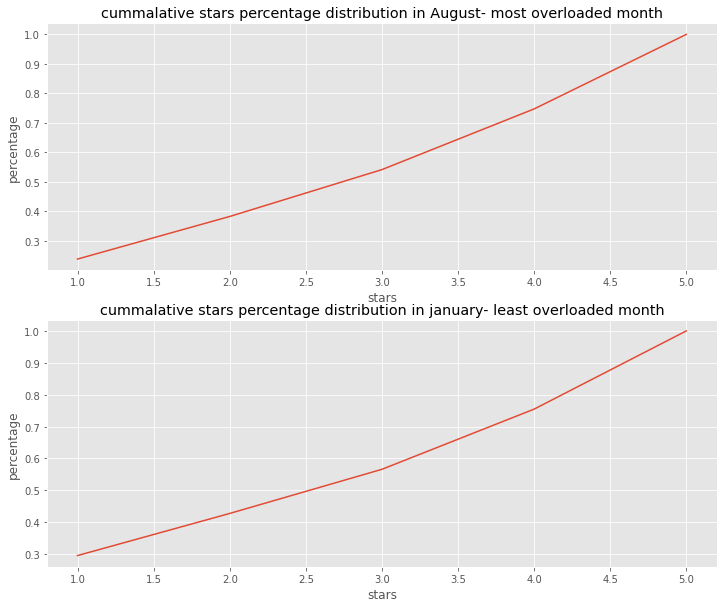

In [229]:
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
(((reviews_at_most_crowded_month.groupby('stars').size()) / reviews_at_most_crowded_month.shape[0]).cumsum()).plot()
plt.title('cummalative stars percentage distribution in August- most overloaded month')
plt.ylabel('percentage')
plt.xlabel('stars')
plt.subplot(2,1,2)
(((reviews_at_least_crowded_month.groupby('stars').size()) / reviews_at_least_crowded_month.shape[0]).cumsum()).plot()
plt.title('cummalative stars percentage distribution in january- least overloaded month')
plt.ylabel('percentage')
plt.xlabel('stars')

- low rating(stars<3) is larger in januray  rating≈0.5  while in august it is slightly less than 0.5, but they both converge to 0.5
- high rating(stars>3) is larger in slightly august ≈ 0.45 vs january ≈ 0.4

In [230]:
print(f'mean of stars in august: {reviews_at_most_crowded_month.stars.mean():9f}')
print(f'mean of stars in january: {reviews_at_least_crowded_month.stars.mean():2f}')

mean of stars in august:  3.090253
mean of stars in january: 2.955975


- we can see the mean of stars is very similar
- in general, the distribution is quite similar

### distribution of cool, funny, useful upvotes for reviews in August vs january


No handles with labels found to put in legend.


Text(0.5, 1.0, 'useful reviews percentage distribution in january')

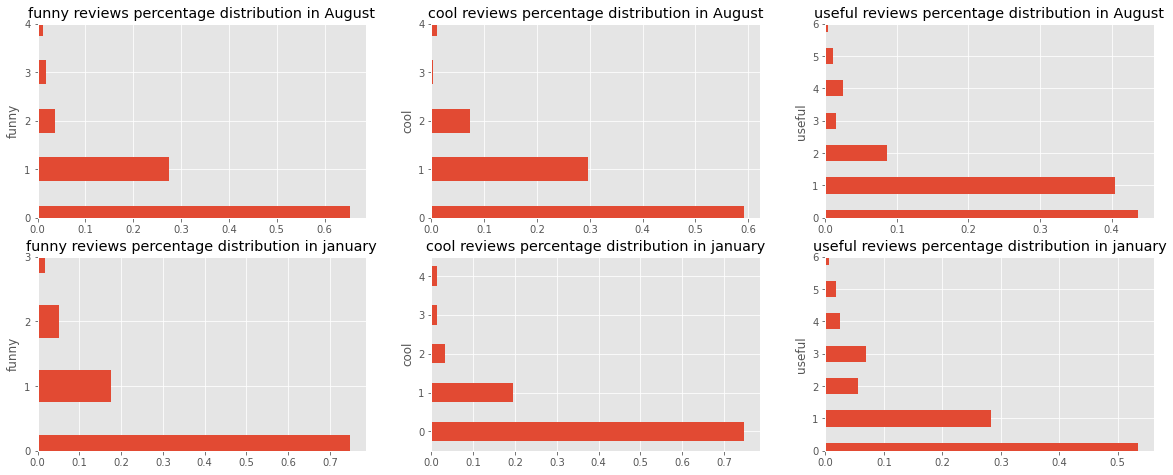

In [231]:
condition=reviews_at_most_crowded_month.columns.str.contains("cool|funny|useful")
plt.figure(figsize=(20,25))
plt.legend()
plt.subplot(6,3,1)
((reviews_at_most_crowded_month.loc[:,condition].groupby('funny').size())/ reviews_at_most_crowded_month.shape[0]).plot.barh()
plt.ylim([0,4])
plt.title('funny reviews percentage distribution in August')
plt.subplot(6,3,2)
((reviews_at_most_crowded_month.loc[:,condition].groupby('cool').size())/ reviews_at_most_crowded_month.shape[0]).plot.barh()
plt.ylim([0,4])
plt.title('cool reviews percentage distribution in August')
plt.subplot(6,3,3)
((reviews_at_most_crowded_month.loc[:,condition].groupby('useful').size())/ reviews_at_most_crowded_month.shape[0]).plot.barh()
plt.ylim([0,6])
plt.title('useful reviews percentage distribution in August')
plt.subplot(6,3,4)
((reviews_at_least_crowded_month.loc[:,condition].groupby('funny').size())/ reviews_at_least_crowded_month.shape[0]).plot.barh()
plt.ylim([0,3])
plt.title('funny reviews percentage distribution in january')
plt.subplot(6,3,5)
((reviews_at_least_crowded_month.loc[:,condition].groupby('cool').size())/ reviews_at_least_crowded_month.shape[0]).plot.barh()
plt.title('cool reviews percentage distribution in january')
plt.subplot(6,3,6)
((reviews_at_least_crowded_month.loc[:,condition].groupby('useful').size())/ reviews_at_least_crowded_month.shape[0]).plot.barh()
plt.ylim([0,6])
plt.title('useful reviews percentage distribution in january')


- in the overloaded month - the reviews are labeled as funnier, cooler, more useful 

### mean of stars,useful,funny,cool columns in most overloaded month

In [232]:
reviews_at_most_crowded_month.describe().loc['mean'].drop('stars',axis=0)

useful    1.371841
funny     0.714801
cool      0.989170
Name: mean, dtype: float64

### mean of stars,useful,funny,cool columns in least overloaded month

In [233]:
reviews_at_least_crowded_month.describe().loc['mean'].drop('stars',axis=0)

useful    0.974843
funny     0.371069
cool      0.345912
Name: mean, dtype: float64

- that could be because of the "timeliness" effect --> the quality of something being done or occurring at a favorable or useful time. the reviews that were upvoted more on average as useful happened in a month where there were a lot of checkins - a lot of interest in the restaurant- which is a time that people look more for reviews and guidance. funny and cool upvotes difference could happen because of the same reason, obviously there are many more factors that we didn't look for in this project

In [234]:
#explain about the user dataset...
user.head(3)

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
116,2dl7lGBoYtH_05Nxw1lxvw,Kristen,73,2010-06-02 20:49:33,265,330,165,2011,"dUh7r34hPvcyRU4BSFhRMA, elF_FFErHXfp4QFK4nD73g, sSsyNu1NyMneLlU_FGJ9jA, 2l0O1EI1m0yWjFo2zSt71w, AlNiBDCWl-Q1_1OuDKUc7A, 0OhcNToaDdLU0vS7uPkYNQ, U4INQZOPSUaj8hMjLlZ3KA, FQP16KOZRgGaNE_hS-rbug, NQn4xfxJ_-G5uPr15jQmXA, wSByVbwME4MzgkJaFyfvNg, IrBr1IBag-P9NKOzcFsSKA, WMqcyFZ7iqfJLyduJXkH6g, 8v8P4UGspJCDiFOCAG-nvA, JUlMVyJQ6ijHCdMjs8bGhw, n-tnLvDl95IyxvCSRhIUZg, IhAg0AiGv68AEIGX3H-kOw, 9FYh8Eaxx0CZ...",12,3.80,7,1,3,1,4,14,12,19,19,18,0
407,xhVlmdU1sPVH6GBJw6AZtQ,Joseph,211,2010-11-14 21:50:32,639,339,447,"2012,2013,2014,2015,2016,2017,2018","G6PW_2q9Ilobc85nvpNYGQ, UsmTxWbobLsI6WR1Db0W7A, 3qdOo7aWhIHWrKuT9jw3Gg, rCWrxuRC8_pfagpchtHp6A, 9VDrCkfj0I_MDSDPgsPKFA, nHxQfB9CRettoPKJmkDx_A, Lfv4hefW1VbvaC2gatTFWA, UQWRkukIHFgTyZVkrwx99w, KidcYew8ArXQStKOMjQ7JQ, BjtJ3VkMOxV2Lan037AFuw, 4wp4XI9AxKNqJima-xahlg, hSJKiiHNgUpRRRIgUixfoQ, -2OB54nQ6FsGLUM-R1KXnA, 6XJrBy1DtlHvzeAAAT2ltQ, AyYKTOCL5qM8589oBsqbfA, TkFcPIHDPx43OqnqZ_ElPQ, J1gc2iMG-xAF...",16,4.04,29,10,0,0,0,15,27,33,33,30,0
732,vc4mkEa6Ug5cQudS0EfytQ,Irene,1021,2009-10-18 21:29:30,6625,3962,5566,"2010,2011,2012,2013,2014,2015,2016,2017,2018","KOkOFxhyGMKWsHslO2cfMw, mr8V4_2wAC4H6JxQbDvxsA, wFVz-VdXiwFNDnfUdIQp5g, _lhZLCKN3j41uucUIqFy-A, 9eKk90OB9wKDacTDyYvFWg, nFktsO7R7QL6hs_OUbk04w, n26rAuTl76G6DWmbaSbuzQ, dLts9bY66tXEFqYG03YFgw, q8OdcTdl_VEsw-zL8Vwrqw, J5rxPAMYjlpuKoCcC_z47Q, uyps9svWZWyqhVyf-FigYQ, KKmAxwT82ADE28GjIU69Ow, taPq7IxYskEWH7Vfc261pQ, kuBRpMGnr4ol8P61MZAoNA, faeaincB9rdJdGwOt1lVuA, moJsK6NKYS7mmc7N445_9Q, Goz8916C5_cQ...",193,4.28,365,35,52,16,10,168,338,516,516,282,71


In [235]:
user['yelping_since']=user.yelping_since.apply(lambda x:pd.to_datetime(x))

# is there a link between number of reviews and popularity?




Text(0.5, 1.0, 'distribution of fans accross review_counts groups')

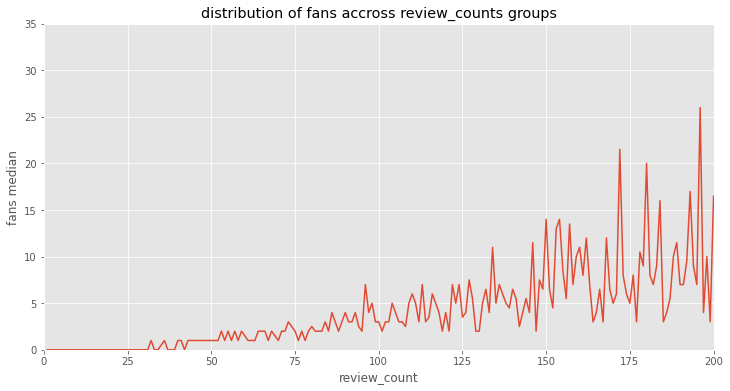

In [236]:
plt.figure(figsize=(12,6))
user.groupby('review_count').fans.median().plot()
plt.ylim([0,35])
plt.xlim([0,200])
plt.ylabel('fans median')
plt.title('distribution of fans accross review_counts groups')


- it seems like there is a positive relation between review_counts and fans


# is there a link between popularity and usefulness upvotes

Text(0.5, 1.0, 'distribution of usefulness upvotes as a function of popularity')

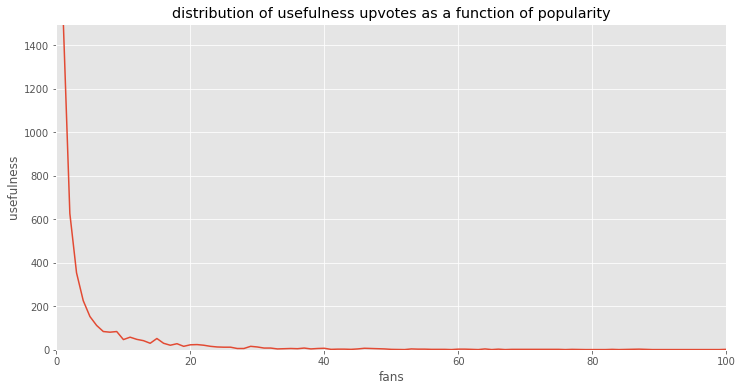

In [252]:
plt.figure(figsize=(12,6))
user.groupby('fans').useful.count().plot()
plt.xlim([0,100])
plt.ylim([0,1500])
plt.ylabel('usefulness')
plt.title('distribution of usefulness upvotes as a function of popularity')

- there is negative relation between usefulness upvotes and popularity

# How many elite users are there by years

In [238]:
elite_years = user.elite.str.split(',', expand=True)
elite_years.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
116,2011,None,None,None,None,None,None,None,None,None,None,None,None
407,2012,2013,2014,2015,2016,2017,2018,None,None,None,None,None,None
732,2010,2011,2012,2013,2014,2015,2016,2017,2018,None,None,None,None
830,2014,2015,2016,2017,2018,None,None,None,None,None,None,None,None
851,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,None


In [239]:
elite_count = user.elite.str.split(',\d+', expand=True).stack().value_counts()
elite_count

        15502
2018      515
2017      305
2016      193
2015      155
2014       82
2012       57
2011       44
2013       42
2010       31
2009       14
2007        7
2008        4
2006        2
dtype: int64

# How many elite, active, inactive users are there (all time)?


In [240]:
f'the percentage of elite users from all users is: {(user[~user.elite.apply(lambda x:x=="")].shape[0])/(user.shape[0]):.0%}'

'the percentage of elite users from all users is: 10%'

### we will define inactivity as a user who last left a review (1 year+) before december 2019 - the newest review date, we will check the date of the last post by the user by accessing the review dataset

In [241]:
def activity(id:str)->bool:
    last_review=review[review.user_id==id].date.dt.year.max()
    if last_review<=2018:
        return False
    else:
        return True

In [242]:
user['active']=user.user_id.apply(activity)

In [243]:
f'the percentage of active users from all users is: {(user.active.sum())/user.shape[0]:.0%}'

'the percentage of active users from all users is: 52%'

# Do elite status users, with many friends and compliments, rate differently?

In [244]:
elite_users=user[~user.elite.apply(lambda x:x=="")]
other_users=user[user.elite.apply(lambda x:x=="")]

Text(0.5, 1.0, 'distribution of average stars amongst other_users')

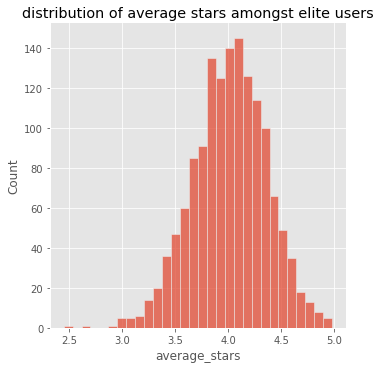

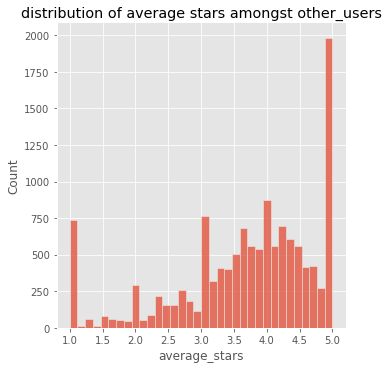

In [245]:
sns.displot(data=elite_users,x='average_stars')
plt.title('distribution of average stars amongst elite users')
sns.displot(data=other_users,x='average_stars')
plt.title('distribution of average stars amongst other_users')

- elite users rarely give a 5 star review, they also rarely give a negative review(star<3) - while other users give a lot of those reviews
- elite users seem to give ratings mostly between 3.5 and 4.5 , while other users dont have a specific pattern

# Friends reviews

In [246]:
user_friends = user[['user_id', 'friends']].assign(friends=user.friends.str.split(',')).explode('friends').rename(columns={'friends': 'friend_id'})
print(len(user), 'users,', len(user_friends.friend_id.drop_duplicates()), 'friends')
validated_friends = user_friends.friend_id[user_friends.friend_id.isin(user_friends.user_id)].drop_duplicates()
print(len(validated_friends), 'friends with reviews exist in the user table')
reviewers_friends = review[['user_id', 'business_id']].merge(user_friends, on='user_id', how='inner')
friends_reviewing_same_business = reviewers_friends.merge(review[['business_id', 'user_id']], left_on=['business_id', 'friend_id'], right_on=['business_id', 'user_id'], how='inner').drop_duplicates()
print(friends_reviewing_same_business.user_id_x.nunique(), 'users have friends who reviewed the same business')

14600 users, 659557 friends
356 friends with reviews exist in the user table
150 users have friends who reviewed the same business


- This looks pretty amazing... it may mean that very few yelp users ever write a review, or - it may tell us something about the way yelp extracted this data
- we subsetted the user data set according to users who had atleast one review 